In [1]:
import torch
import torch.nn as nn
import torch.distributions as tdist
import torch.nn.functional as F

import dataloader

In [24]:
test = torch.linspace(0, 10, 256 * 3 * 28 * 28).view(256, 3 * 28 * 28)
mha = nn.MultiheadAttention(3 * 28 * 28, 2, batch_first=True)

attention, _ = mha(test, test, test)

In [2]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dim, embedding_size):
        super(DownBlock, self).__init__()
        self.out_channels = out_channels
        self.dim = dim
        self.time = nn.Linear(embedding_size, out_channels * dim * dim)
        self.Conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.Conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.ln = nn.LayerNorm((dim, dim))
        self.Downscale = nn.Conv2d(out_channels, out_channels, 8)
        self.relu = nn.ReLU()

    def forward(self, x, t):

        x = self.ln(self.relu(self.Conv1(x)))
        
        t = self.relu(self.time(t)).view(-1, self.out_channels, self.dim, self.dim)

        x = x + t

        x = self.ln(self.relu(self.Conv2(x)))
        x = self.Downscale(x)

        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dim, embedding_size):
        super(UpBlock, self).__init__()
        self.out_channels = out_channels
        self.dim = dim
        self.time = nn.Linear(embedding_size, out_channels * dim * dim)
        self.Conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.Conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.ln = nn.LayerNorm((dim, dim))
        self.Upscale = nn.ConvTranspose2d(out_channels, out_channels, 8)
        self.relu = nn.ReLU()
    
    def forward(self, x, t):

        x = self.ln(self.relu(self.Conv1(x)))

        t = self.relu(self.time(t)).view(-1, self.out_channels, self.dim, self.dim)

        x = x + t

        x = self.ln(self.relu(self.Conv2(x)))
        x = self.Upscale(x)

        return x

class DiffusionModel2(nn.Module):
    def __init__(self, beta):
        super(DiffusionModel2, self).__init__()
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.beta = beta.to(self.device) # Decay schedule
        self.T = beta.shape[0]

        self.D1 = DownBlock(1, 32, 28, 32) # D1 -> U3
        self.D2 = DownBlock(32, 64, 21, 32) # D2 -> U2
        self.D3 = DownBlock(64, 128, 14, 32)

        self.U1 = UpBlock(128, 64, 7, 32)
        self.U2 = UpBlock(128, 32, 14, 32)
        self.U3 = UpBlock(64, 32, 21, 32)
        
        self.time = nn.Linear(32, 32 * 28 * 28)
        self.ln = nn.LayerNorm((28, 28))
        self.Out1 = nn.Conv2d(32, 16, 3, padding=1)
        self.Out2 = nn.Conv2d(16, 1, 3, padding=1)
        
        self.relu = nn.ReLU()
        
    def alphabar(self, t):
        alpha = torch.zeros(t.shape[0], device=self.device)
        for idx, s in enumerate(t):
            alpha[idx] = torch.prod(1 - self.beta[0:s])
        return alpha

    def embedtime(self, t, embedding_size):
        w = 1.0 / (10000 ** (torch.arange(0, embedding_size, 2, dtype=torch.float32, device=self.device) / embedding_size))
        y = torch.sin(t.view(t.shape[0], 1).repeat(1, embedding_size // 2) * w)
        x = torch.cos(t.view(t.shape[0], 1).repeat(1, embedding_size // 2) * w)
        return torch.cat([x, y], dim=1)

    def sample_image(self):
        samples = torch.zeros((self.T + 1, 784), device=self.device)
        
        samples[self.T] = torch.randn(784, device=self.device)
        
        with torch.no_grad():
            for t in torch.arange(self.T - 1, 0, -1):
                beta = self.beta[t]
                alfa = 1 - beta
                alfabar = self.alphabar(torch.tensor([t + 1], device=self.device))
                z = torch.randn(784, device=self.device)
                xt = samples[t + 1]
                eps = self.forward(xt.view(1, 1, 28, 28), torch.tensor([t + 1], device=self.device)).view(784)
                samples[t] = (xt - beta * eps / (torch.sqrt(1 - alfabar))) / torch.sqrt(alfa) + torch.sqrt(beta) * z
            
            beta = self.beta[0]
            alfa = 1 - beta
            alfabar  = self.alphabar(torch.tensor([1], device=self.device))
            xt = samples[1]
            eps = self.forward(xt.view(1, 1, 28, 28), torch.tensor([1], device=self.device)).view(784)
            samples[0] = (xt - beta * eps / (torch.sqrt(1 - alfabar))) / torch.sqrt(alfa)
        
        return samples

    def forward(self, x, t):
        T = self.embedtime(t, 32)
        x_to_U3 = self.D1(x, T)
        x_to_U2 = self.D2(x_to_U3, T)
        
        x = self.D3(x_to_U2, T)
        x = self.U1(x, T)
        
        x = torch.cat([x, x_to_U2], dim=1)
        x = self.U2(x, T)
        
        x = torch.cat([x, x_to_U3], dim=1)
        x = self.U3(x, T)
        
        Tx = self.relu(self.time(T))
        x = Tx.view(-1, 32, 28, 28) + x
        x = self.ln(self.relu(self.Out1(x)))
        x = self.Out2(x)

        return x

In [3]:
def train_diff(epoch, model, optimizer, loss_function, train_loader):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    input = torch.zeros((train_loader.batch_size, 784), device = model.device)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        
        t = torch.randint(1, model.T, (train_loader.batch_size,))
        eps = torch.normal(0, 1, (train_loader.batch_size, 784))
        alf = model.alphabar(t)
        for idx, x in enumerate(data):
            input[idx] = torch.sqrt(alf[idx]) * data[idx] + torch.sqrt(1 - alf[idx]) * eps[idx]
        eps_nn = model(input.view(-1, 1, 28, 28), t)
        loss = loss_function(eps.view(-1, 784), eps_nn.view(-1, 784))
        loss.backward()
        train_loss += loss.item()
        optimizer.step() # backpropagation
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [4]:
model = DiffusionModel2(torch.linspace(1e-4, 0.02, 1000))
loss = nn.MSELoss()
train_loader, test_loader = dataloader.setup_data_loaders(batch_size=512, use_cuda=False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [5]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train_diff(epoch, model, optimizer, loss, train_loader)

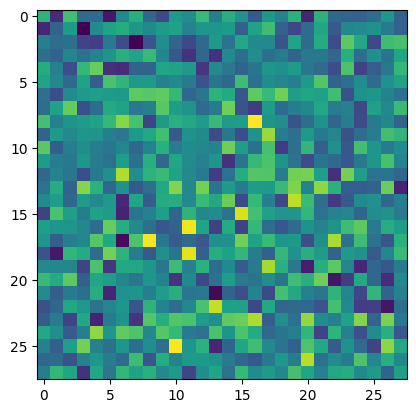

In [66]:
import matplotlib.pyplot as plt



EOFError: Ran out of input

In [81]:
model = DiffusionModel2(torch.linspace(1e-4, 0.02, 1000))
weights = torch.load('diffusionmodelunet.pth', torch.device('cpu'))
model.load_state_dict(weights())


<All keys matched successfully>

In [87]:
test = model.sample_image()

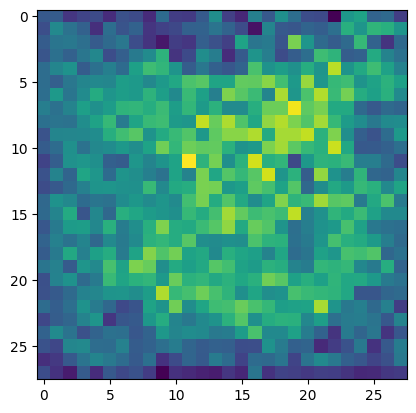

In [88]:
import matplotlib.pyplot as plt

plt.imshow(test[0].view(28, 28))